# Import Packages and Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import cv2
from PIL import Image
import timeit

In [2]:
import torch
from torchvision import datasets, transforms

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# Label mapping for Y
# img_label_mapping = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
# classes = len (img_label_mapping)
# classes

In [4]:
def is_colab():
  try:
    import google.colab
    return True
  except ImportError:
    return False

# Example usage:
is_colab = is_colab()
is_colab

False

# Load data

## Load from file

In [5]:
if is_colab == True:
  from google.colab import drive
  drive.mount('/content/drive')

In [6]:
if is_colab == True:
  path = '/content/drive/MyDrive/GeorgiaTech/08_DL_CS7643/Project/Data/intel_image'
  sys.path.append (path)
  data_path = path + '/raw_data/'
else:
#   data_path = 'data/intel_image/raw_data/'
  data_path = 'data/'  #on PACE

In [7]:
# def get_data (type='training'):
#     _df_X = pd.read_parquet(data_path + type + '_X.parquet')
#     _df_X['X'] = _df_X['X_flat'].apply(lambda x: x.reshape(100, 100, 3))
#     if type != 'pred':
#         _df_Y = pd.read_parquet(data_path + type + '_Y.parquet')
#         return pd.DataFrame({'X': _df_X['X'], 'Y': _df_Y['Y']})
#     else:
#         return pd.DataFrame({'X': _df_X['X']})

In [8]:
# df_train = get_data('training')
# df_test  = get_data('testing')
# df_pred  = get_data('pred')
# print (df_train.info())
# print ('\n')
# print (df_test.info())
# print ('\n')
# print (df_pred.info())

In [9]:
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor()])

In [10]:
train_data = datasets.ImageFolder(data_path + 'seg_train', transform=transform)
test_data = datasets.ImageFolder(data_path + 'seg_test', transform=transform)

In [11]:
batch_size = 32

In [12]:
# use the ImageFolder dataset to create the DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [13]:
print (type (train_data))
print (f'Length of Train data & Test data = {len (train_data)} & {len (test_data)}' )
print (f'Image shape = {train_data[0][0].shape}') # 3, 224, 224 (RGB, 224x224)
print (f'Number of classes = {len (train_data.classes)}')
print (f'Classes = {train_data.classes}')
print (f'Class to index mapping = {train_data.class_to_idx}')
for i in range (len (train_data.classes)):
    print (f'Number of images per class {i} = {train_data.targets.count(i)}')

print (f'Label of first image = {train_data[0][1]} ;  Class = {train_data.classes[train_data[0][1]]}')

<class 'torchvision.datasets.folder.ImageFolder'>
Length of Train data & Test data = 14034 & 3000
Image shape = torch.Size([3, 224, 224])
Number of classes = 6
Classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Class to index mapping = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Number of images per class 0 = 2191
Number of images per class 1 = 2271
Number of images per class 2 = 2404
Number of images per class 3 = 2512
Number of images per class 4 = 2274
Number of images per class 5 = 2382
Label of first image = 0 ;  Class = buildings


In [68]:
classes = train_data.classes
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [14]:
# type (train_data.class_to_idx)
train_data.class_to_idx.items()

dict_items([('buildings', 0), ('forest', 1), ('glacier', 2), ('mountain', 3), ('sea', 4), ('street', 5)])

In [15]:
# train_data[0][0].shape[1:3] == (224,224)
train_data[0][0].shape  == (3,224,224)

True

In [16]:
# # Are all train_data in shape 3,224,224?
# for i in range (len (train_data)):
#     if train_data[i][0].shape  != (3,224,224):
#       print (f"Image {i} has shape {train_data[i][0].shape}")

In [17]:
print (train_data[0][1])
print (len (train_data[0]))

0
2


In [18]:
print (type (train_loader))
print (len (train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
439


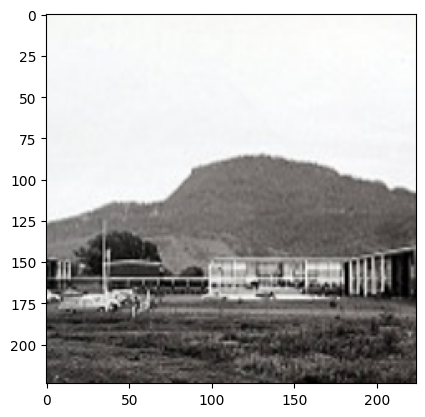

In [19]:
plt.imshow (train_data[0][0].permute(1, 2, 0))  # permute to change the order of the dimensions from (C, W, H) to (W, H, C)

## Test the image load

In [20]:
# Run this to test your data loader
images, labels = next(iter(train_loader))

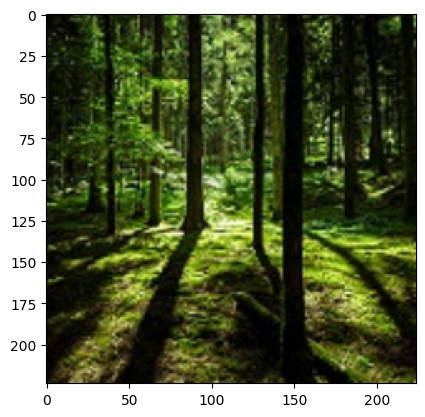

In [21]:
plt.imshow (images[0].permute(1, 2, 0))  # permute to change the order of the dimensions from (C, W, H) to (W, H, C)

In [22]:
print (labels[0])
print (labels[0].item())

tensor(1)
1


In [23]:
def print_images (df_images, df_labels, n=15, nrow=3, title='Intel Images'):
    ncol = int (n/nrow)
    if nrow==5:
      figsize = (20,20)
    else:
      figsize = (15,15)
    fig, ax = plt.subplots (nrows=nrow, ncols=ncol, figsize=figsize)
    fig.suptitle(title)
    for i in range(n):
        # idx = np.random.randint(0, len(df_image))

        _row = i//ncol
        _col = i%ncol
        ax[_row,_col].imshow(df_images[i].permute(1, 2, 0))
        # ax[_row,_col].set_title(img_label_mapping[df_labels[i].item()] )
        ax[_row,_col].set_title(train_data.classes[df_labels[i].item()])
        ax[_row,_col].axis('off')

In [19]:
# _images = 16
# print_images (train_data [0:_images,0], train_data [0:_images,1],_images,4)  #16 images in 4 row


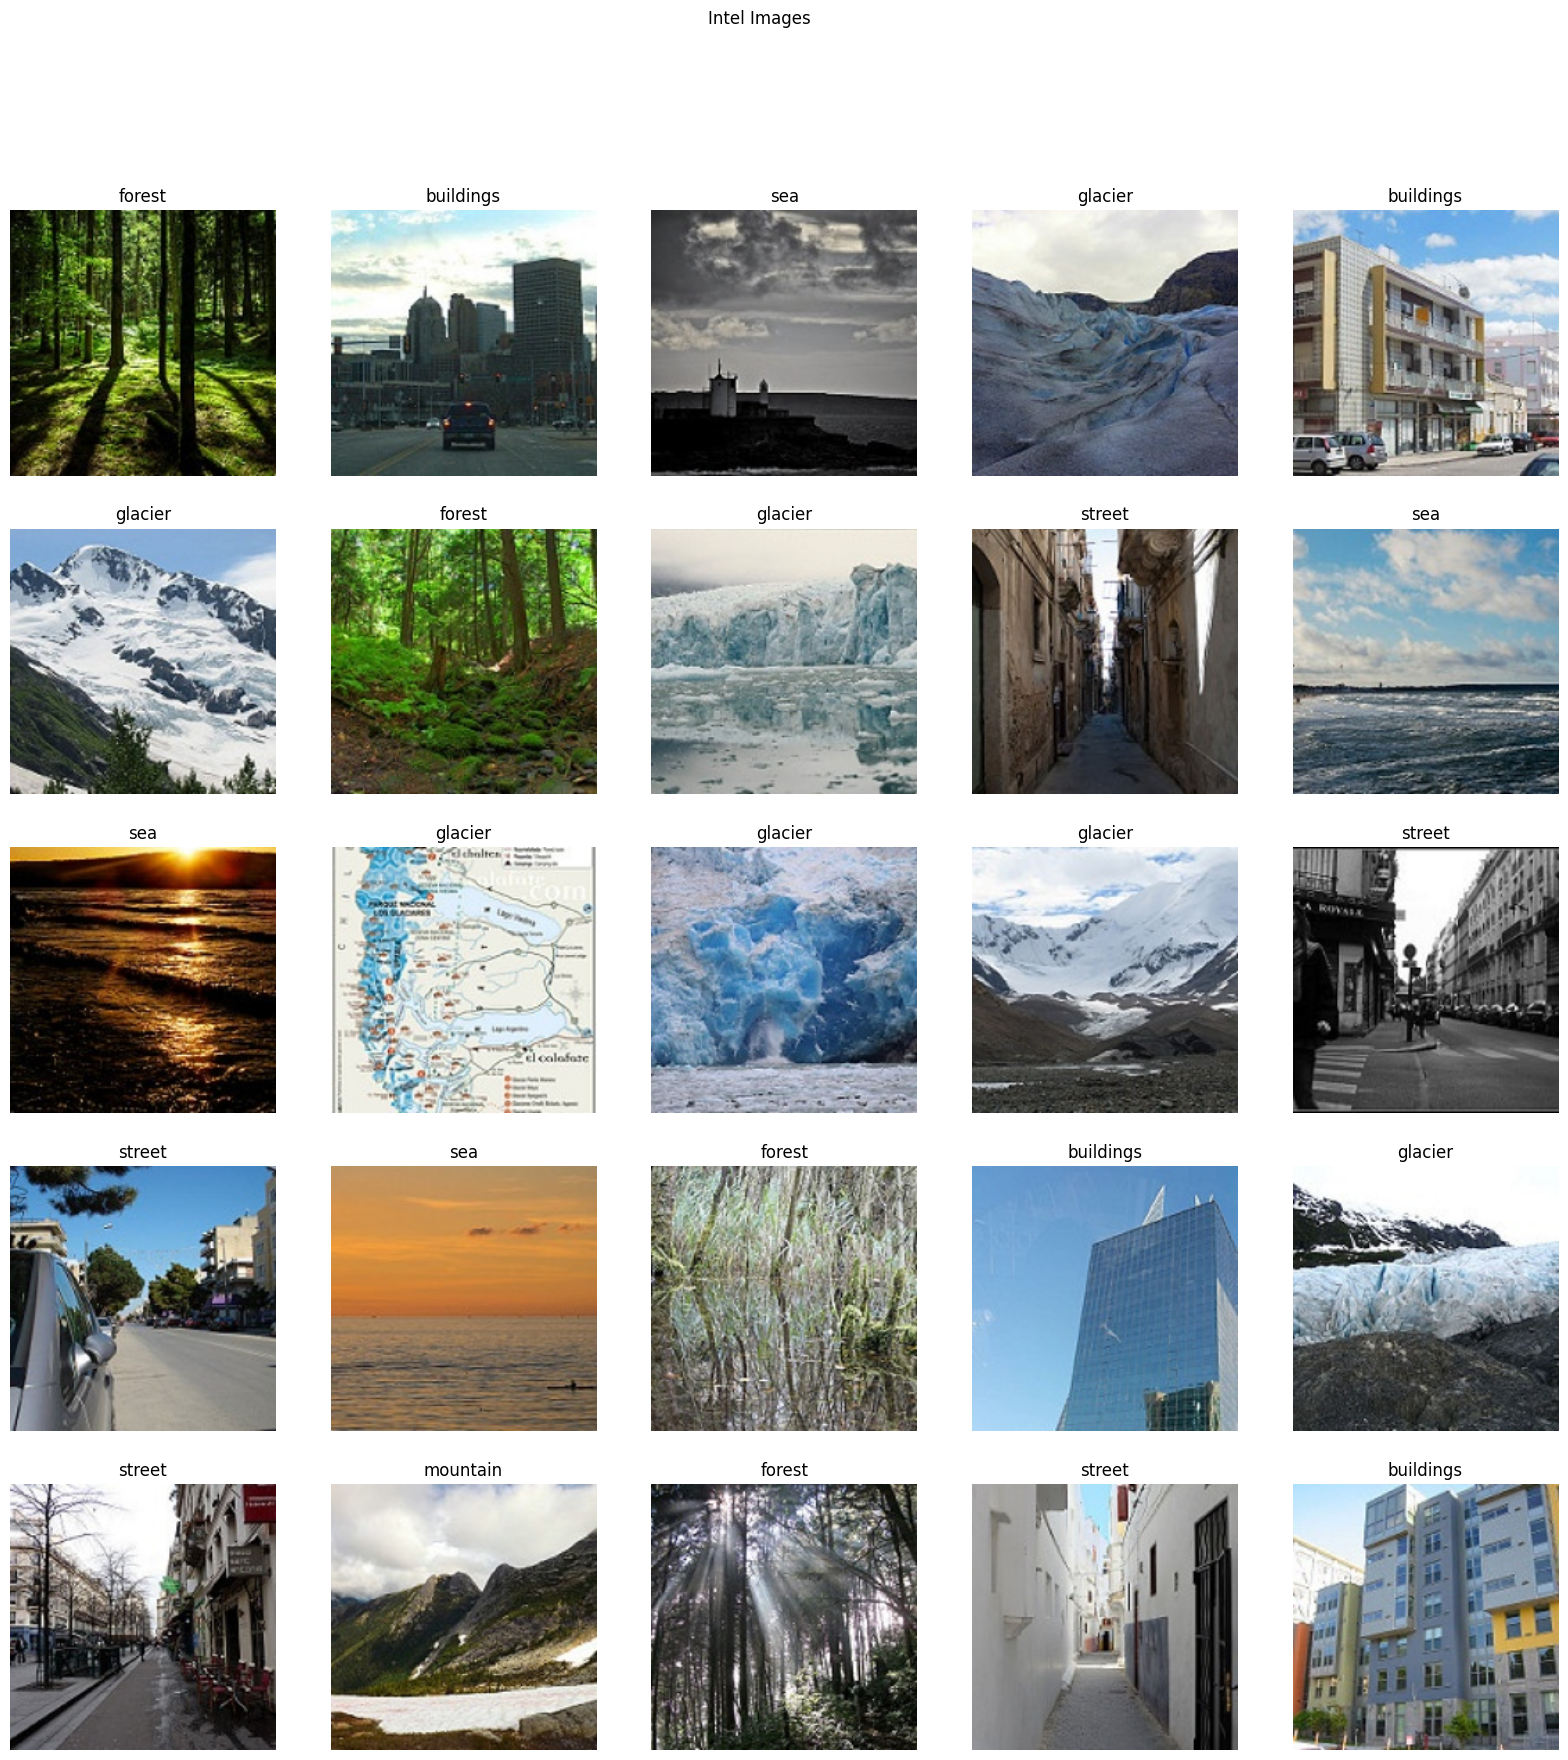

In [24]:
# print_images (images, labels,16,4)  #16 images in 4 row
print_images (images, labels,25,5)  #25 images in 5 row

# Vision Transformer VTi model

inspired by :
https://colab.research.google.com/drive/1eQS3NZ8gPhTGd98o88rKZ0nYZJMg7Ujq#scrollTo=b6676a19

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [26]:
from torch.utils.data         import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [27]:
import torchvision
import torchvision.transforms as T
import torchvision.models as models
import torchvision.transforms as T
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [28]:
# Hyper parameter
batch_size = 32


## Define data loaders

In [29]:
# percentage of training set to use as validation
valid_size = 0.2

# get training indices that wil be used for validation
train_size = len(train_data)
indices = list(range(train_size))
np.random.shuffle(indices)
split = int(np.floor(valid_size * train_size))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers to obtain training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [30]:
print (f"Original train data = {train_size}, \nAfter split 80:20 : {train_size-split} & {split}")

Original train data = 14034, 
After split 80:20 : 11228 & 2806


In [47]:
# # print out classes statistics

# # get all training samples labels
# train_labels = [labels for i, (images, labels) in enumerate(train_loader)]
# train_labels = torch.cat((train_labels), 0)
# train_labels_count = train_labels.unique(return_counts=True)

# # print(train_labels_count)

# print('The number of samples per classes in training dataset:\n')
# for label, count in zip(train_labels_count[0], train_labels_count[1]):
#     print('\t {}: {}'.format(label, count))

# # get all test samples labels
# test_labels = [labels for i, (images, labels) in enumerate(test_loader)]
# test_labels = torch.cat((test_labels), 0)
# test_labels_count = test_labels.unique(return_counts=True)

# print()
# print('The number of samples per classes in test dataset:\n')
# for label, count in zip(test_labels_count[0], test_labels_count[1]):
#     print('\t {}: {}'.format(label, count))

## Transformer model with pretrained weight

In [31]:
# define model
vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
vision_transformer

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/hice1/arachman6/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 341MB/s] 


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [32]:
# vit-16 model is trained on ImageNet
# we expect to have output of 1000 number of classes

vision_transformer.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [34]:
classes = len (train_data.classes)
print (classes)
print (train_data.classes)

6
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [35]:
# fine-tune with dataset

# change the number of output classes
vision_transformer.heads = nn.Linear(in_features=768, out_features=classes, bias=True)

# freeze the parameters except the last linear layer
#
# freeze weights
for p in vision_transformer.parameters():
    p.requires_grad = False

# unfreeze weights of classification head to train
for p in vision_transformer.heads.parameters():
    p.requires_grad = True

In [36]:
# check whether corresponding layers are frozen

for layer_name, p in vision_transformer.named_parameters():
    print('Layer Name: {}, Frozen: {}'.format(layer_name, not p.requires_grad))
    print()

Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.0.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.0.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.3.weight, Fro

In [37]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
# only train the parameters with requires_grad set to True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001)


In [38]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

=======================

In [ ]:
# first_rows = df_train.iloc[0:16]
# first_rows
# images = first_rows['X']
# targets = first_rows['Y']
# len (images)

16

In [ ]:
# image_resize =  cv2.resize (images[0], (16,14))

In [ ]:
# image_size = 224

# # define transform
# transform = T.Compose([ T.Resize(image_size), T.ToTensor() ])

In [ ]:
# # image_tensor = transform(images[0])
# # Convert the numpy array to a PIL Image before applying the transform
# image_tensor = transform(Image.fromarray(images[0].astype(np.uint8)))

In [39]:
# # prompt: create a new variable to resize image of  df_train.iloc[0]['X'] to image size = 224 and transform it to a Tensor.

# # Assuming df_train.iloc[0]['X'] is a NumPy array representing an image

# image_tensor = transform(image_resize)

# # Check if the image tensor is on the GPU if available, otherwise keep it on the CPU
# if train_on_gpu:
#     image_tensor = image_tensor.cuda()

# resized_image_tensor = image_tensor

In [40]:
# images_tensor = torch.tensor(images)
# targets_tensor = torch.tensor (targets)

==============================

In [ ]:
# image_size = 224

# # define transform
# transform = T.Compose([ T.Resize(image_size), T.ToTensor() ])

# # Function to transform a single NumPy array image
# def transform_image(image_np):
#     """Transforms a single NumPy array image to a PyTorch tensor."""
#     image_pil = Image.fromarray(image_np.astype(np.uint8))
#     return transform(image_pil)

In [43]:
20 % 10 == 0

True

In [82]:
# Train model

# number of epochs
n_epoch = 10

train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    vision_transformer.to('cuda')
    
# prepare model for training
vision_transformer.train()

starttime = timeit.default_timer()    

for e in range(n_epoch):
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in enumerate(train_loader):
        if i % 50 == 0:
            print (f'Batch {i+1} of {len(train_loader)}')

        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to('cuda'), targets.to('cuda')

        # clear grad
        optimizer.zero_grad()

        # feedforward data
        outputs = vision_transformer(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vision_transformer.eval()

    print ('Validating model')

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to('cuda')
            targets = targets.to('cuda')

        # turn off gradients
        with torch.no_grad():

            outputs = vision_transformer(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                  .format( (e+1), train_loss, valid_loss))


print ('\n')
print(f"Time Taken for training of {len (train_data)} train_data = {starttime} - {timeit.default_timer()} = {timeit.default_timer() - starttime} seconds ")
print(f" in minutes : { (timeit.default_timer() - starttime)/60} minutes ")

Batch 1 of 351
Batch 51 of 351
Batch 101 of 351
Batch 151 of 351
Batch 201 of 351
Batch 251 of 351
Batch 301 of 351
Batch 351 of 351
Validating model
Epoch: 1 	 Training Loss: 0.189063 	 Validation Loss: 0.211514
Batch 1 of 351
Batch 51 of 351
Batch 101 of 351
Batch 151 of 351
Batch 201 of 351
Batch 251 of 351
Batch 301 of 351
Batch 351 of 351
Validating model
Epoch: 2 	 Training Loss: 0.186867 	 Validation Loss: 0.210448
Batch 1 of 351
Batch 51 of 351
Batch 101 of 351
Batch 151 of 351
Batch 201 of 351
Batch 251 of 351
Batch 301 of 351
Batch 351 of 351
Validating model
Epoch: 3 	 Training Loss: 0.184836 	 Validation Loss: 0.209267
Batch 1 of 351
Batch 51 of 351
Batch 101 of 351
Batch 151 of 351
Batch 201 of 351
Batch 251 of 351
Batch 301 of 351
Batch 351 of 351
Validating model
Epoch: 4 	 Training Loss: 0.182975 	 Validation Loss: 0.208793
Batch 1 of 351
Batch 51 of 351
Batch 101 of 351
Batch 151 of 351
Batch 201 of 351
Batch 251 of 351
Batch 301 of 351
Batch 351 of 351
Validating mode

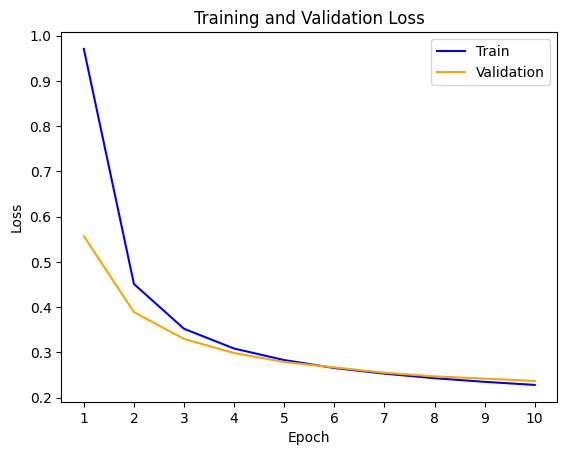

In [45]:
# visualize loss statistics

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# plot losses
x = list(range(1, n_epoch + 1))
plt.plot(x, train_loss_list, color ="blue", label='Train')
plt.plot(x, valid_loss_list, color="orange", label='Validation')
plt.legend(loc="upper right")
plt.xticks(x)

plt.show()

In [75]:
# Save the model
torch.save(vision_transformer.state_dict(),'vision_transformer.pt')
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [80]:
starttime = timeit.default_timer()

# prepare model for evaluation
vision_transformer.eval()

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(classes)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# # move model back to cpu
# vision_transformer = vision_transformer.to('cpu')

if train_on_gpu:
    vision_transformer.to('cuda')
else:
    vision_transformer = vision_transformer.to('cpu')



# test model
for images, targets in test_loader:
    
    # move to gpu if available
    if train_on_gpu:
        images, targets = images.to('cuda'), targets.to('cuda')
    

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    # get correct predictions
    if train_on_gpu:
        correct_preds = (preds == targets).type(torch.cuda.FloatTensor)    
    else:
        correct_preds = (preds == targets).type(torch.FloatTensor)
#     if train_on_gpu:
#         correct_preds.to('cuda')

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

#         targets = targets.to('cpu')
        if train_on_gpu:
            targets = targets.to('cuda')
        else:
            targets = targets.to('cpu')


        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))
print('Accuracy : {:.6f}'.format(accuracy))

print ('\n')
print(f"Time Taken for inference of {len (test_data)} rows = {starttime} - {timeit.default_timer()} = {timeit.default_timer() - starttime} seconds ")

Test Loss: 0.240351
Accuracy : 91.478280


Time Taken for inference of 3000 rows = 4772148.56849007 - 4772160.303028603 = 11.734540041536093 seconds 


In [69]:
class_accuracy = class_correct / class_total

print('Test Accuracy of Classes')
print()

for c in range(n_class):
    print('{}\t: {}% \t ({}/{})'.format(classes[c],
                                int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )

    

print()
print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                           int(np.sum(class_correct)), int(np.sum(class_total)) ))

Test Accuracy of Classes

buildings	: 92% 	 (404/437)
forest	: 99% 	 (471/474)
glacier	: 81% 	 (449/553)
mountain	: 87% 	 (457/525)
sea	: 97% 	 (496/510)
street	: 93% 	 (468/501)

Test Accuracy of Dataset: 	 91% 	 (2745/3000)


## Transformer Model without pretrained weights

In [83]:
# define model
vision_transformer_no_weights = models.vit_b_16()
vision_transformer_no_weights

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [98]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
# only train the parameters with requires_grad set to True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer_no_weights.parameters()), lr=0.001)

In [99]:
# fine-tune with dataset

# change the number of output classes
# vision_transformer_no_weights.heads = nn.Linear(in_features=768, out_features=classes, bias=True)

# freeze the parameters except the last linear layer
#
# freeze weights
for p in vision_transformer_no_weights.parameters():
    p.requires_grad = False

# unfreeze weights of classification head to train
for p in vision_transformer_no_weights.heads.parameters():
    p.requires_grad = True

In [103]:
# Train model

# number of epoch
n_epoch = 30

train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    vision_transformer_no_weights.to('cuda')
    
# prepare model for training
vision_transformer_no_weights.train()

starttime = timeit.default_timer()    

for e in range(n_epoch):
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in enumerate(train_loader):
        if i % 50 == 0:
            print (f'Batch {i+1} of {len(train_loader)}')

        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to('cuda'), targets.to('cuda')

        # clear grad
        optimizer.zero_grad()

        # feedforward data
        outputs = vision_transformer_no_weights(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # track loss
        train_loss += loss.item()

    # set model to evaluation mode
    vision_transformer_no_weights.eval()

    print ('Validating model')

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to('cuda')
            targets = targets.to('cuda')

        # turn off gradients
        with torch.no_grad():

            outputs = vision_transformer_no_weights(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to training mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                  .format( (e+1), train_loss, valid_loss))


print ('\n')
print(f"Time Taken for training of {len (train_data)} train_data = {starttime} - {timeit.default_timer()} = {timeit.default_timer() - starttime} seconds ")
print(f" in minutes : { (timeit.default_timer() - starttime)/60} minutes ")

Batch 1 of 351
Batch 51 of 351
Batch 101 of 351
Batch 151 of 351
Batch 201 of 351
Batch 251 of 351
Batch 301 of 351
Batch 351 of 351
Validating model
Epoch: 1 	 Training Loss: 1.039672 	 Validation Loss: 1.063278
Batch 1 of 351
Batch 51 of 351
Batch 101 of 351
Batch 151 of 351
Batch 201 of 351
Batch 251 of 351
Batch 301 of 351
Batch 351 of 351
Validating model
Epoch: 2 	 Training Loss: 1.035052 	 Validation Loss: 1.027615
Batch 1 of 351
Batch 51 of 351
Batch 101 of 351
Batch 151 of 351
Batch 201 of 351
Batch 251 of 351
Batch 301 of 351
Batch 351 of 351
Validating model
Epoch: 3 	 Training Loss: 1.035496 	 Validation Loss: 1.057705
Batch 1 of 351
Batch 51 of 351
Batch 101 of 351
Batch 151 of 351
Batch 201 of 351
Batch 251 of 351
Batch 301 of 351
Batch 351 of 351
Validating model
Epoch: 4 	 Training Loss: 1.034537 	 Validation Loss: 1.102384
Batch 1 of 351
Batch 51 of 351
Batch 101 of 351
Batch 151 of 351
Batch 201 of 351
Batch 251 of 351
Batch 301 of 351
Batch 351 of 351
Validating mode

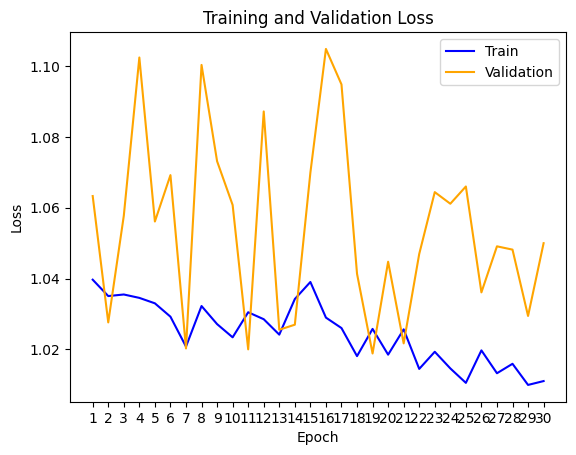

In [104]:
# visualize loss statistics

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# plot losses
x = list(range(1, n_epoch + 1))
plt.plot(x, train_loss_list, color ="blue", label='Train')
plt.plot(x, valid_loss_list, color="orange", label='Validation')
plt.legend(loc="upper right")
plt.xticks(x)

plt.show()

In [90]:
# Save the model
torch.save(vision_transformer_no_weights.state_dict(),'vision_transformer_without_pretrained_weights.pt')
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [105]:
starttime = timeit.default_timer()

# prepare model for evaluation
vision_transformer_no_weights.eval()

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(classes)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# # move model back to cpu
# vision_transformer = vision_transformer.to('cpu')

if train_on_gpu:
    vision_transformer_no_weights.to('cuda')
else:
    vision_transformer_no_weights = vision_transformer_no_weights.to('cpu')



# test model
for images, targets in test_loader:
    
    # move to gpu if available
    if train_on_gpu:
        images, targets = images.to('cuda'), targets.to('cuda')
    

    # get outputs
    outputs = vision_transformer_no_weights(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    # get correct predictions
    if train_on_gpu:
        correct_preds = (preds == targets).type(torch.cuda.FloatTensor)    
    else:
        correct_preds = (preds == targets).type(torch.FloatTensor)
#     if train_on_gpu:
#         correct_preds.to('cuda')

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

#         targets = targets.to('cpu')
        if train_on_gpu:
            targets = targets.to('cuda')
        else:
            targets = targets.to('cpu')


        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))
print('Accuracy : {:.6f}'.format(accuracy))

print ('\n')
print(f"Time Taken for inference of {len (test_data)} rows = {starttime} - {timeit.default_timer()} = {timeit.default_timer() - starttime} seconds ")

Test Loss: 1.083284
Accuracy : 57.524379


Time Taken for inference of 3000 rows = 4779514.624335134 - 4779521.892472965 = 7.268139213323593 seconds 


In [106]:
class_accuracy = class_correct / class_total

print('Test Accuracy of Classes')
print()

for c in range(n_class):
    print('{}\t: {}% \t ({}/{})'.format(classes[c],
                                int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )

    

print()
print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                           int(np.sum(class_correct)), int(np.sum(class_total)) ))

Test Accuracy of Classes

buildings	: 59% 	 (262/437)
forest	: 86% 	 (412/474)
glacier	: 39% 	 (218/553)
mountain	: 68% 	 (358/525)
sea	: 61% 	 (312/510)
street	: 33% 	 (166/501)

Test Accuracy of Dataset: 	 57% 	 (1728/3000)
